In [31]:
# GLR, No L1/L2 Norm
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import sys

def general_linear_regression(data_file, output_file=None):
    """
    Perform general linear regression with various terms
    
    Parameters:
    -----------
    data_file : str
        Path to Excel file containing data. Last column is y, all others are x variables.
    output_file : str, optional
        Path to save results. If None, results are just printed.
    """
    # Read data from Excel
    try:
        data = pd.read_excel(data_file)
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None
    
    # Separate x and y
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    # Create feature matrices for each transformation, then concatenate at the end
    feature_names = ['mean_atomic_radius',]
    feature_dataframes = []
    
    for col in X.columns:
        x_vals = X[col].values
        
        # Create a dictionary of transformations for this column
        column_transforms = {
            f'{col}': x_vals,               # Original term: b * x
            f'{col}^2': x_vals**2,          # x^2 term
            f'{col}^3': x_vals**3,          # x^3 term
            f'{col}^4': x_vals**4,          # x^4 term (replacing 1/x)
            f'e^{col}': np.exp(x_vals),     # e^x term
            f'e^-{col}': np.exp(-x_vals)    # e^-x term
        }
        
        # Add to feature names and create a DataFrame for this column's transformations
        feature_names.extend(list(column_transforms.keys()))
        feature_dataframes.append(pd.DataFrame(column_transforms))
    
    # Add constant term (intercept)
    const_df = pd.DataFrame({'constant': np.ones(len(y))})
    feature_names.append('constant')
    feature_dataframes.append(const_df)
    
    # Concatenate all feature DataFrames at once
    transformed_X = pd.concat(feature_dataframes, axis=1)
    
    # Convert to numpy array for Pyomo
    X_array = transformed_X.values
    
    # Create Pyomo model
    model = pyo.ConcreteModel()
    
    # Define sets
    model.N = pyo.RangeSet(0, len(y)-1)  # Data points
    model.F = pyo.RangeSet(0, len(feature_names)-1)  # Features
    
    # Define parameters
    model.x = pyo.Param(model.N, model.F, initialize=lambda m, i, j: X_array[i, j])
    model.y = pyo.Param(model.N, initialize=lambda m, i: y.iloc[i])
    
    # Define variables (coefficients)
    model.beta = pyo.Var(model.F, domain=pyo.Reals, initialize=2000)
    
    # Define objective function (minimize sum of squared errors)
    def obj_rule(m):
        return sum((m.y[i] - sum(m.beta[j] * m.x[i, j] for j in m.F))**2 for i in m.N)
    
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)
    
    # Solve the model
    solver = SolverFactory('ipopt')
    results = solver.solve(model, tee=True)
    
    # Check if solver found a solution
    if results.solver.termination_condition != pyo.TerminationCondition.optimal:
        print("Solver did not find an optimal solution")
        return None
    
    # Extract and print coefficients
    coefficients = {}
    for j in model.F:
        coefficients[feature_names[j]] = pyo.value(model.beta[j])
    
    coef_df = pd.DataFrame(list(coefficients.items()), columns=['Term', 'Coefficient'])
    print("\nRegression Coefficients:")
    print(coef_df)
    
    # Calculate fitted values and various metrics
    y_pred = []
    for i in model.N:
        y_pred.append(sum(pyo.value(model.beta[j]) * X_array[i, j] for j in model.F))
    
    mse = np.mean((y - y_pred)**2)
    rmse = np.sqrt(mse)
    r_squared = 1 - (np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2))
    
    print(f"\nMean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    
    # Print the regression equation
    print("\nRegression Equation:")
    equation = "y = "
    terms = []
    
    for term, coef in coefficients.items():
        if term == 'constant':
            if coef >= 0:
                terms.append(f"{coef:.6f}")
            else:
                # If constant is negative, it will be added with the sign
                terms = [f"{coef:.6f}"]
        else:
            if abs(coef) > 1e-10:  # Only include terms with non-zero coefficients
                sign = "+ " if coef > 0 else "- "
                # Don't add "+ " for the first term if it's not the constant
                if not terms and coef > 0:
                    sign = ""
                terms.append(f"{sign}{abs(coef):.6f} * {term}")
    
    equation += " ".join(terms)
    print(equation)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    
    # Save results if output file provided
    if output_file:
        with pd.ExcelWriter(output_file) as writer:
            coef_df.to_excel(writer, sheet_name='Coefficients', index=False)
            pd.DataFrame([{'MSE': mse, 'RMSE': rmse, 'R-squared': r_squared}]).to_excel(
                writer, sheet_name='Metrics', index=False)
            pd.DataFrame({'actual': y, 'predicted': y_pred}).to_excel(
                writer, sheet_name='Predictions', index=False)
            
            # Save equation to Excel
            pd.DataFrame({'Equation': [equation]}).to_excel(
                writer, sheet_name='Equation', index=False)
        
        plt.savefig(output_file.replace('.xlsx', '.png'))
        print(f"\nResults saved to {output_file}")
    
    plt.show()
    return coefficients, y_pred, {'mse': mse, 'rmse': rmse, 'r_squared': r_squared, 'equation': equation}

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   118828

Total number of variables............................:      487
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


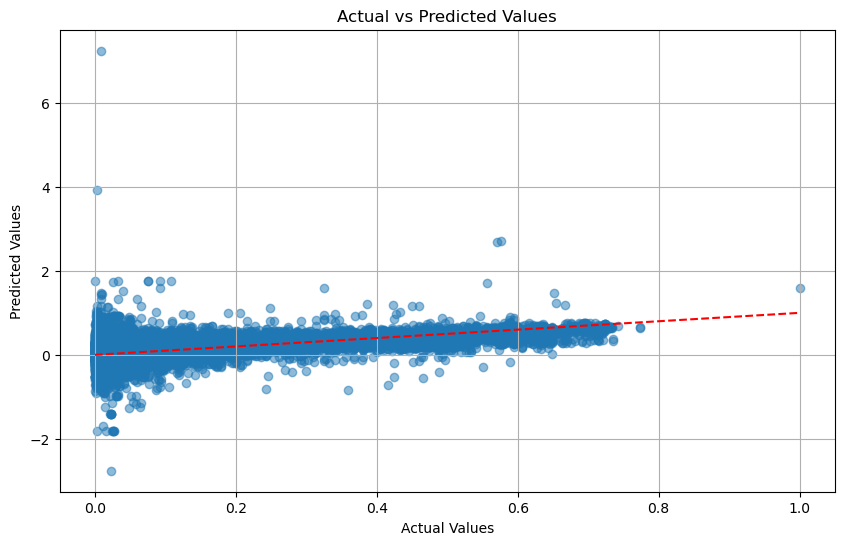

({'number_of_elements': 1370.9145179424781,
  'number_of_elements^2': 480.1087526292813,
  'number_of_elements^3': -173.99541016485938,
  'number_of_elements^4': 172.6519155580474,
  'e^number_of_elements': -774.626500871216,
  'e^-number_of_elements': 1221.2987090489091,
  'mean_atomic_mass': 1543.297409436615,
  'mean_atomic_mass^2': 16.49648535731731,
  'mean_atomic_mass^3': 246.75213827802912,
  'mean_atomic_mass^4': 26.438235936152303,
  'e^mean_atomic_mass': -789.5000704632201,
  'e^-mean_atomic_mass': 750.8165766107956,
  'wtd_mean_atomic_mass': 1544.0760831457205,
  'wtd_mean_atomic_mass^2': 7.008157433549908,
  'wtd_mean_atomic_mass^3': 258.06438767215803,
  'wtd_mean_atomic_mass^4': 22.891477207813544,
  'e^wtd_mean_atomic_mass': -792.6112997337132,
  'e^-wtd_mean_atomic_mass': 743.6950929900978,
  'gmean_atomic_mass': 1544.3314090115982,
  'gmean_atomic_mass^2': 33.68830622730337,
  'gmean_atomic_mass^3': 209.2374824305161,
  'gmean_atomic_mass^4': 42.68623590356882,
  'e^gm

In [33]:
general_linear_regression('train_normalized.xlsx', 'GLR_NoL1orL2_full_output_file.xlsx')

In [47]:
# GLR, L2 Norm
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import sys

def general_linear_regression_L2(data_file, output_file=None):
    """
    Perform general linear regression with various terms
    
    Parameters:
    -----------
    data_file : str
        Path to Excel file containing data. Last column is y, all others are x variables.
    output_file : str, optional
        Path to save results. If None, results are just printed.
    """
    # Read data from Excel
    try:
        data = pd.read_excel(data_file)
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None
    
    # Separate x and y
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    # Create feature matrices for each transformation, then concatenate at the end
    feature_names = []
    feature_dataframes = []
    
    for col in X.columns:
        x_vals = X[col].values
        
        # Create a dictionary of transformations for this column
        column_transforms = {
            f'{col}': x_vals,               # Original term: b * x
            f'{col}^2': x_vals**2,          # x^2 term
            f'{col}^3': x_vals**3,          # x^3 term
            f'{col}^4': x_vals**4,          # x^4 term (replacing 1/x)
            f'e^{col}': np.exp(x_vals),     # e^x term
            f'e^-{col}': np.exp(-x_vals)    # e^-x term
        }
        
        # Add to feature names and create a DataFrame for this column's transformations
        feature_names.extend(list(column_transforms.keys()))
        feature_dataframes.append(pd.DataFrame(column_transforms))
    
    # Add constant term (intercept)
    const_df = pd.DataFrame({'constant': np.ones(len(y))})
    feature_names.append('constant')
    feature_dataframes.append(const_df)
    
    # Concatenate all feature DataFrames at once
    transformed_X = pd.concat(feature_dataframes, axis=1)
    
    # Convert to numpy array for Pyomo
    X_array = transformed_X.values
    
    # Create Pyomo model
    model = pyo.ConcreteModel()
    
    # Define sets
    model.N = pyo.RangeSet(0, len(y)-1)  # Data points
    model.F = pyo.RangeSet(0, len(feature_names)-1)  # Features
    
    # Define parameters
    model.x = pyo.Param(model.N, model.F, initialize=lambda m, i, j: X_array[i, j])
    model.y = pyo.Param(model.N, initialize=lambda m, i: y.iloc[i])
    
    # Define variables (coefficients)
    model.beta = pyo.Var(model.F, domain=pyo.Reals, initialize=2000)
    
    # Define objective function (minimize sum of squared errors)
    def obj_rule(m):
        return sum((m.y[i] - sum(m.beta[j] * m.x[i, j] for j in m.F))**2 for i in m.N) + 0.001 * sum(m.beta[j]**2 for j in m.F)
    
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)
    
    # Solve the model
    solver = SolverFactory('ipopt')
    results = solver.solve(model, tee=True)
    
    # Check if solver found a solution
    if results.solver.termination_condition != pyo.TerminationCondition.optimal:
        print("Solver did not find an optimal solution")
        return None
    
    # Extract and print coefficients
    coefficients = {}
    for j in model.F:
        coefficients[feature_names[j]] = pyo.value(model.beta[j])
    
    coef_df = pd.DataFrame(list(coefficients.items()), columns=['Term', 'Coefficient'])
    print("\nRegression Coefficients:")
    print(coef_df)
    
    # Calculate fitted values and various metrics
    y_pred = []
    for i in model.N:
        y_pred.append(sum(pyo.value(model.beta[j]) * X_array[i, j] for j in model.F))
    
    mse = np.mean((y - y_pred)**2)
    rmse = np.sqrt(mse)
    r_squared = 1 - (np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2))
    
    print(f"\nMean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    
    # Print the regression equation
    print("\nRegression Equation:")
    equation = "y = "
    terms = []
    
    for term, coef in coefficients.items():
        if term == 'constant':
            if coef >= 0:
                terms.append(f"{coef:.6f}")
            else:
                # If constant is negative, it will be added with the sign
                terms = [f"{coef:.6f}"]
        else:
            if abs(coef) > 1e-10:  # Only include terms with non-zero coefficients
                sign = "+ " if coef > 0 else "- "
                # Don't add "+ " for the first term if it's not the constant
                if not terms and coef > 0:
                    sign = ""
                terms.append(f"{sign}{abs(coef):.6f} * {term}")
    
    equation += " ".join(terms)
    print(equation)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    
    # Save results if output file provided
    if output_file:
        with pd.ExcelWriter(output_file) as writer:
            coef_df.to_excel(writer, sheet_name='Coefficients', index=False)
            pd.DataFrame([{'MSE': mse, 'RMSE': rmse, 'R-squared': r_squared}]).to_excel(
                writer, sheet_name='Metrics', index=False)
            pd.DataFrame({'actual': y, 'predicted': y_pred}).to_excel(
                writer, sheet_name='Predictions', index=False)
            
            # Save equation to Excel
            pd.DataFrame({'Equation': [equation]}).to_excel(
                writer, sheet_name='Equation', index=False)
        
        plt.savefig(output_file.replace('.xlsx', '.png'))
        print(f"\nResults saved to {output_file}")
    
    plt.show()
    return coefficients, y_pred, {'mse': mse, 'rmse': rmse, 'r_squared': r_squared, 'equation': equation}

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   118828

Total number of variables............................:      487
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


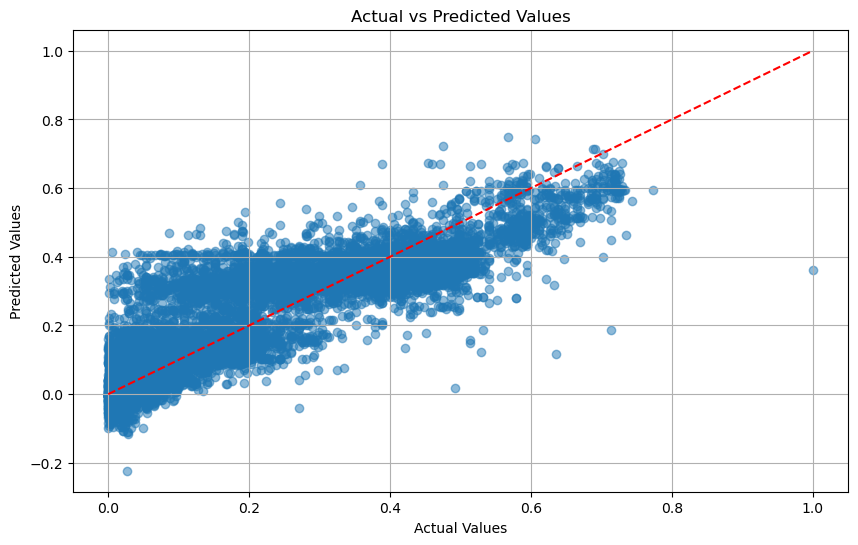

({'number_of_elements': -2.1201718495506157,
  'number_of_elements^2': 0.6660790427827123,
  'number_of_elements^3': 0.7128778566311667,
  'number_of_elements^4': 0.01281536247142867,
  'e^number_of_elements': -1.548876694081855,
  'e^-number_of_elements': 2.4334107536153624,
  'mean_atomic_mass': -0.4333588497645451,
  'mean_atomic_mass^2': -1.179149201543396,
  'mean_atomic_mass^3': 3.8826937045610066,
  'mean_atomic_mass^4': -2.772595160108267,
  'e^mean_atomic_mass': -0.46141176900232495,
  'e^-mean_atomic_mass': -0.7429189921606394,
  'wtd_mean_atomic_mass': 0.059373531821393044,
  'wtd_mean_atomic_mass^2': -0.8256841415882263,
  'wtd_mean_atomic_mass^3': 0.29250753748056013,
  'wtd_mean_atomic_mass^4': -0.17593212773658706,
  'e^wtd_mean_atomic_mass': -0.10687958337575765,
  'e^-wtd_mean_atomic_mass': -0.46241629843962073,
  'gmean_atomic_mass': 0.20110914877318464,
  'gmean_atomic_mass^2': -0.025828237729456305,
  'gmean_atomic_mass^3': -0.8345185457390016,
  'gmean_atomic_mass^

In [49]:
general_linear_regression_L2('train_training.xlsx', 'GLR_L2_0.001_output_file.xlsx')

In [27]:
# GLR, L2 Norm with PCA
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def general_linear_regression_PCA(data_file, output_file=None, n_components=None):
    """
    Perform general linear regression with various terms and optional PCA.

    Parameters:
    -----------
    data_file : str
        Path to Excel file containing data. Last column is y, all others are x variables.
    output_file : str, optional
        Path to save results. If None, results are just printed.
    n_components : int or None, optional
        Number of PCA components to keep. If None, PCA is not applied.
    """
    # Read data from Excel
    try:
        data = pd.read_excel(data_file)
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

    # Separate x and y
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Create feature matrices for each transformation, then concatenate at the end
    feature_names = []
    feature_dataframes = []

    for col in X.columns:
        x_vals = X[col].values

        # Create a dictionary of transformations for this column
        column_transforms = {
            f'{col}': x_vals,               # Original term: b * x
            f'{col}^2': x_vals**2,          # x^2 term
            f'{col}^3': x_vals**3,          # x^3 term
            f'{col}^4': x_vals**4,          # x^4 term (replacing 1/x)
            f'e^{col}': np.exp(x_vals),     # e^x term
            f'e^-{col}': np.exp(-x_vals)    # e^-x term
        }

        # Add to feature names and create a DataFrame for this column's transformations
        feature_names.extend(list(column_transforms.keys()))
        feature_dataframes.append(pd.DataFrame(column_transforms))

    # Add constant term (intercept)
    const_df = pd.DataFrame({'constant': np.ones(len(y))})
    feature_names.append('constant')
    feature_dataframes.append(const_df)

    # Concatenate all feature DataFrames at once
    transformed_X = pd.concat(feature_dataframes, axis=1)

    # Convert to numpy array
    X_array_raw = transformed_X.values

    # Apply PCA if requested
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_array = pca.fit_transform(X_array_raw)
        feature_names = [f'PC{i+1}' for i in range(X_array.shape[1])]
    else:
        X_array = X_array_raw

    # Create Pyomo model
    model = pyo.ConcreteModel()

    # Define sets
    model.N = pyo.RangeSet(0, len(y)-1)  # Data points
    model.F = pyo.RangeSet(0, len(feature_names)-1)  # Features

    # Define parameters
    model.x = pyo.Param(model.N, model.F, initialize=lambda m, i, j: X_array[i, j])
    model.y = pyo.Param(model.N, initialize=lambda m, i: y.iloc[i])

    # Define variables (coefficients)
    model.beta = pyo.Var(model.F, domain=pyo.Reals, initialize=2000)

    # Define objective function (minimize sum of squared errors with L2 regularization)
    def obj_rule(m):
        return sum((m.y[i] - sum(m.beta[j] * m.x[i, j] for j in m.F))**2 for i in m.N) + \
               0.001 * sum(m.beta[j]**2 for j in m.F)

    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Solve the model
    solver = SolverFactory('ipopt')
    results = solver.solve(model, tee=True)

    # Check if solver found a solution
    if results.solver.termination_condition != pyo.TerminationCondition.optimal:
        print("Solver did not find an optimal solution")
        return None

    # Extract and print coefficients
    coefficients = {}
    for j in model.F:
        coefficients[feature_names[j]] = pyo.value(model.beta[j])

    coef_df = pd.DataFrame(list(coefficients.items()), columns=['Term', 'Coefficient'])
    print("\nRegression Coefficients:")
    print(coef_df)

    # Calculate fitted values and metrics
    y_pred = []
    for i in model.N:
        y_pred.append(sum(pyo.value(model.beta[j]) * X_array[i, j] for j in model.F))

    mse = np.mean((y - y_pred)**2)
    rmse = np.sqrt(mse)
    r_squared = 1 - (np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2))

    print(f"\nMean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R-squared: {r_squared:.4f}")

    # Print regression equation
    print("\nRegression Equation:")
    equation = "y = "
    terms = []

    for term, coef in coefficients.items():
        if term == 'constant':
            if coef >= 0:
                terms.append(f"{coef:.6f}")
            else:
                terms = [f"{coef:.6f}"]
        else:
            if abs(coef) > 1e-10:  # Only include terms with non-zero coefficients
                sign = "+ " if coef > 0 else "- "
                if not terms and coef > 0:
                    sign = ""
                terms.append(f"{sign}{abs(coef):.6f} * {term}")

    equation += " ".join(terms)
    print(equation)

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)

    # Save results
    if output_file:
        with pd.ExcelWriter(output_file) as writer:
            coef_df.to_excel(writer, sheet_name='Coefficients', index=False)
            pd.DataFrame([{'MSE': mse, 'RMSE': rmse, 'R-squared': r_squared}]).to_excel(
                writer, sheet_name='Metrics', index=False)
            pd.DataFrame({'actual': y, 'predicted': y_pred}).to_excel(
                writer, sheet_name='Predictions', index=False)
            pd.DataFrame({'Equation': [equation]}).to_excel(
                writer, sheet_name='Equation', index=False)

        plt.savefig(output_file.replace('.xlsx', '.png'))
        print(f"\nResults saved to {output_file}")

    plt.show()

    return coefficients, y_pred, {
        'mse': mse,
        'rmse': rmse,
        'r_squared': r_squared,
        'equation': equation,
        'pca': pca if n_components is not None else None
    }


Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   118828

Total number of variables............................:      487
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


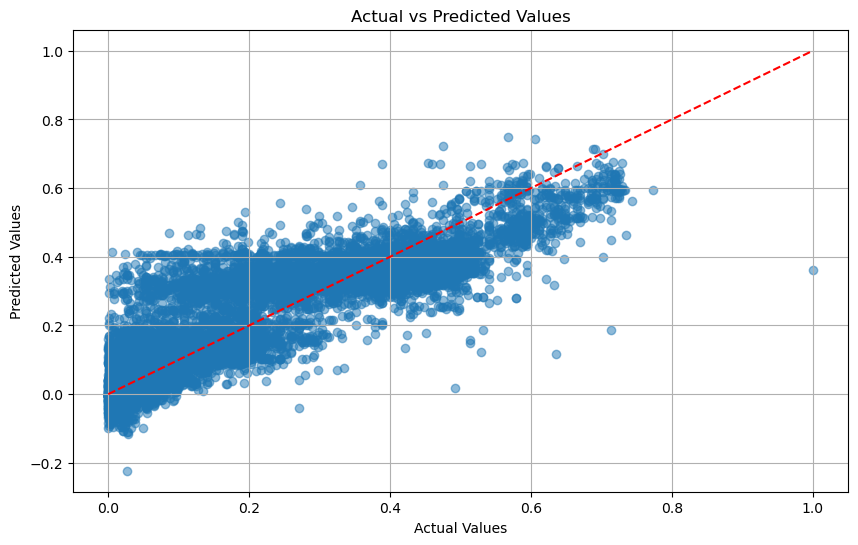

({'number_of_elements': -2.1201718495506157,
  'number_of_elements^2': 0.6660790427827123,
  'number_of_elements^3': 0.7128778566311667,
  'number_of_elements^4': 0.01281536247142867,
  'e^number_of_elements': -1.548876694081855,
  'e^-number_of_elements': 2.4334107536153624,
  'mean_atomic_mass': -0.4333588497645451,
  'mean_atomic_mass^2': -1.179149201543396,
  'mean_atomic_mass^3': 3.8826937045610066,
  'mean_atomic_mass^4': -2.772595160108267,
  'e^mean_atomic_mass': -0.46141176900232495,
  'e^-mean_atomic_mass': -0.7429189921606394,
  'wtd_mean_atomic_mass': 0.059373531821393044,
  'wtd_mean_atomic_mass^2': -0.8256841415882263,
  'wtd_mean_atomic_mass^3': 0.29250753748056013,
  'wtd_mean_atomic_mass^4': -0.17593212773658706,
  'e^wtd_mean_atomic_mass': -0.10687958337575765,
  'e^-wtd_mean_atomic_mass': -0.46241629843962073,
  'gmean_atomic_mass': 0.20110914877318464,
  'gmean_atomic_mass^2': -0.025828237729456305,
  'gmean_atomic_mass^3': -0.8345185457390016,
  'gmean_atomic_mass^

In [29]:
general_linear_regression_PCA('train_training.xlsx', 'GLR_PCA_output_file.xlsx')

In [33]:
# GLR, L2 Norm with PCA, 5-Fold CV, Min-Max Normalization
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

def general_linear_regression_PCA(data_file, output_file=None, n_components=None, n_splits=5):
    """
    General Linear Regression with PCA, 5-fold CV, and Min-Max Scaling on both X and y.

    Parameters:
    -----------
    data_file : str
        Path to Excel file. Last column = target y, others = input features X.
    output_file : str, optional
        Path to save results.
    n_components : int or None
        PCA components to keep.
    n_splits : int
        Number of cross-validation folds.
    """
    # Load data
    try:
        data = pd.read_csv(data_file)
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

    X_raw = data.iloc[:, :-1]
    y_raw = data.iloc[:, -1].values.reshape(-1, 1)

    # Min-Max Scaling
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_scaled = pd.DataFrame(x_scaler.fit_transform(X_raw), columns=X_raw.columns)
    y_scaled = y_scaler.fit_transform(y_raw).flatten()

    # Transform features (poly + exp)
    feature_dataframes = []
    feature_names = []

    for col in X_scaled.columns:
        x_vals = X_scaled[col].values
        transforms = {
            f'{col}': x_vals,
            f'{col}^2': x_vals ** 2,
            f'{col}^3': x_vals ** 3,
            f'{col}^4': x_vals ** 4,
            f'e^{col}': np.exp(x_vals),
            f'e^-{col}': np.exp(-x_vals)
        }
        feature_names.extend(transforms.keys())
        feature_dataframes.append(pd.DataFrame(transforms))

    # Add intercept
    const_df = pd.DataFrame({'constant': np.ones(len(y_scaled))})
    feature_dataframes.append(const_df)
    feature_names.append('constant')

    X_transformed = pd.concat(feature_dataframes, axis=1).values

    # Optional PCA
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_final = pca.fit_transform(X_transformed)
        feature_names = [f'PC{i+1}' for i in range(X_final.shape[1])]
    else:
        X_final = X_transformed

    # Cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_final), 1):
        X_train, y_train = X_final[train_idx], y_scaled[train_idx]
        X_test, y_test = X_final[test_idx], y_scaled[test_idx]

        # Build Pyomo model
        model = pyo.ConcreteModel()
        model.N = pyo.RangeSet(0, len(y_train) - 1)
        model.F = pyo.RangeSet(0, X_final.shape[1] - 1)

        model.x = pyo.Param(model.N, model.F, initialize=lambda m, i, j: X_train[i, j])
        model.y = pyo.Param(model.N, initialize=lambda m, i: y_train[i])

        model.beta = pyo.Var(model.F, domain=pyo.Reals, initialize=0)

        def obj_rule(m):
            return sum((m.y[i] - sum(m.beta[j] * m.x[i, j] for j in m.F))**2 for i in m.N) + \
                   0.01 * sum(m.beta[j]**2 for j in m.F)

        model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)
        solver = SolverFactory('ipopt')
        results = solver.solve(model, tee=False)

        beta_values = np.array([pyo.value(model.beta[j]) for j in model.F])
        y_pred_scaled = X_test @ beta_values
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        mse = np.mean((y_true - y_pred) ** 2)
        rmse = np.sqrt(mse)
        r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

        fold_results.append({'fold': fold, 'mse': mse, 'rmse': rmse, 'r2': r2})

        # Plot
        plt.figure(figsize=(7, 5))
        plt.scatter(y_true, y_pred, alpha=0.6)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f'Fold {fold} - Actual vs Predicted')
        plt.grid(True)
        plt.text(0.05, 0.95, f'$R^2$: {r2:.4f}\nRMSE: {rmse:.4f}', transform=plt.gca().transAxes,
                 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
        if output_file:
            plt.savefig(output_file.replace('.xlsx', f'_fold{fold}.png'))
        plt.show()

    result_df = pd.DataFrame(fold_results)
    print("\nCross-validation Results:")
    print(result_df)
    print(f"\nAverage R²: {result_df['r2'].mean():.4f}")
    print(f"Average RMSE: {result_df['rmse'].mean():.4f}")

    if output_file:
        with pd.ExcelWriter(output_file) as writer:
            result_df.to_excel(writer, sheet_name='CV_Results', index=False)
        print(f"\nSaved results to {output_file}")

    return result_df


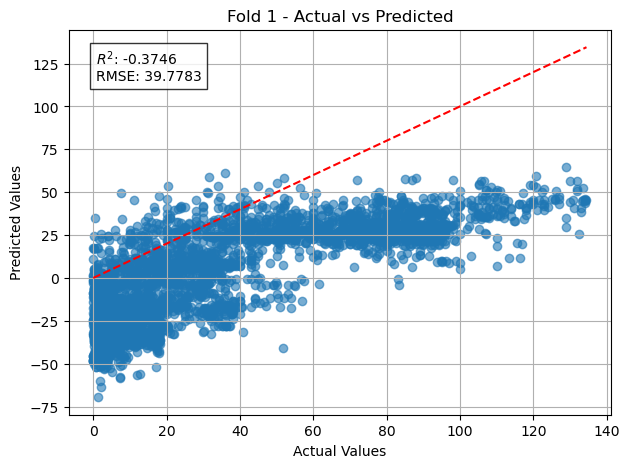

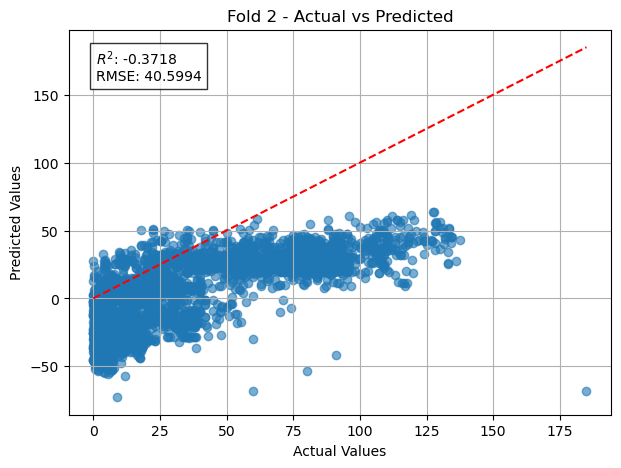

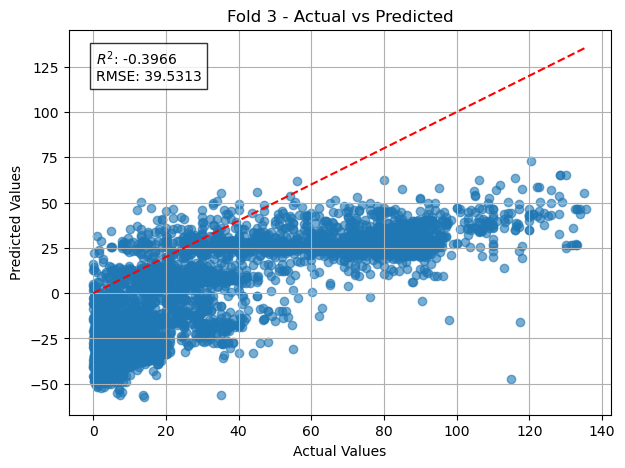

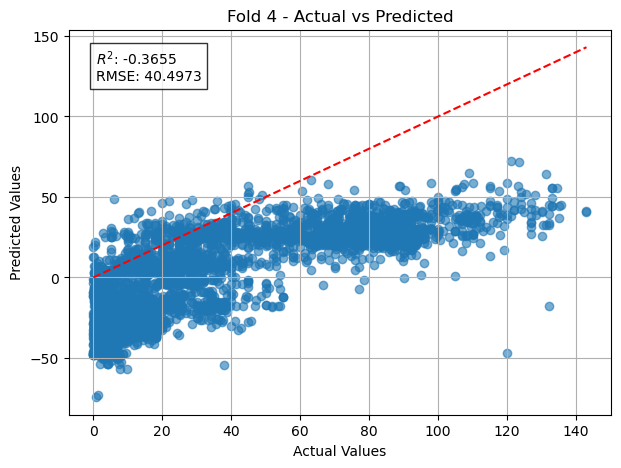

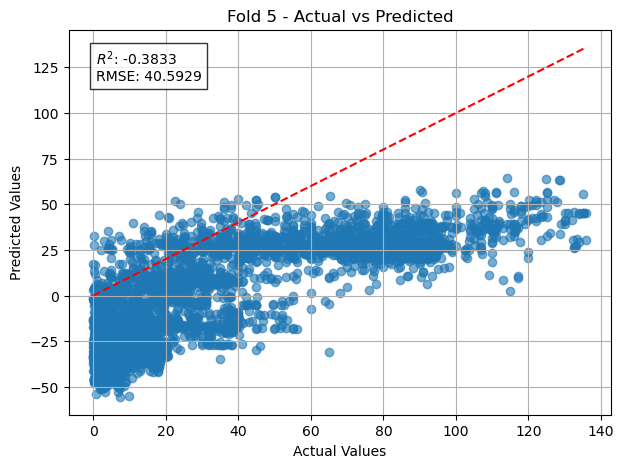


Cross-validation Results:
   fold          mse       rmse        r2
0     1  1582.313184  39.778300 -0.374633
1     2  1648.309485  40.599378 -0.371842
2     3  1562.720027  39.531254 -0.396552
3     4  1640.032350  40.497313 -0.365537
4     5  1647.781194  40.592871 -0.383312

Average R²: -0.3784
Average RMSE: 40.1998

Saved results to normalized_cv_results.xlsx


,fold,mse,rmse,r2
0,1,1582.313184,39.778300,-0.374633
1,2,1648.309485,40.599378,-0.371842
2,3,1562.720027,39.531254,-0.396552
3,4,1640.032350,40.497313,-0.365537
4,5,1647.781194,40.592871,-0.383312


In [37]:
general_linear_regression_PCA(
    data_file="train.csv",
    output_file="normalized_cv_results.xlsx",
    n_components= 15  # optional, None = no PCA
)